# MeowLab

> cat可能是你最常用的命令行工具之一，但是可能很少有人会关注cat的性能问题。
> 
> 但实际上，cat可能比你想的更加高效。在这个lab中，我们会一起来探索cat如此高效的秘密。

## 什么是cat

对于大部分同学来说，这个问题有些太trivial了。但是以防万一，还是在这里介绍一下，cat是一个GNU coreutils中的一个程序，它的作用是连接(con**cat**enate)一系列文件，并将其输出到标准输出流(stdout)中。

> 如果你愿意去找，你会发现这个lab中所有的代码都可以在GNU coreutils中找到，或者你用某个大模型，它可能也能写得不错。
> 但是，除了写代码以外，这个lab中也会包含一些分析和讨论。因此即使你选择直接去抄GNU coreutils中的代码，也不要直接不加思考的复制粘贴。

## 环境要求

* 操作系统：Linux（任何包含GNU coreutils的发行版）
* 编译器：本lab允许使用C/C++或者Rust，选择你喜欢的任何编译器即可。
* Python3.x：本lab一些地方需要你画图，推荐你使用matplotlib。另外，我们使用一个简单的脚本来生成测试文件。

## 在开始之前

这个项目的所有代码需要你自己动手来写，我们只提供了一个用于生成测试文件的脚本。

为了展示比较明显的测试效果，我们会生成一个2GB的测试文件，请确保你的磁盘拥有足够的空间。你可以运行下面这个单元格来查看你的电脑是否有足够的空间。这里我们使用了`df`命令，这个命令的作用是查看某个文件系统所在的磁盘的使用量。

In [7]:
%%bash
df -h /

avail=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[0-9.]*')
unit=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[a-zA-Z]*')
if [[ "$unit" == "M" || "$unit" == "K" ]]; then
    echo "Disk space is low: $avail$unit"
elif [[ "$unit" == "T" ]]; then
    echo "Disk space is sufficient: $avail$unit"
elif [[ "$unit" == "G" ]]; then
    if (( $(echo "$avail < 10" | bc -l) )); then
        echo "Disk space is low: $avail$unit"
    else
        echo "Disk space is sufficient: $avail$unit"
    fi
else
    echo "Unknown unit: $unit"
fi


Filesystem      Size  Used Avail Use% Mounted on
/dev/sdd       1007G   15G  942G   2% /


bash: line 10: bc: command not found


Disk space is sufficient: 942G


你可以使用我们提供的python脚本来生成测试文件，运行下面的单元格。测试文件的生成可能会花费一定的时间。

In [8]:
import random

MB = 1024 * 1024

# A static seed for reproducibility
random.seed(42)

with open("test.txt", "wb") as f:
    for _ in range(2048):
        f.write(random.randbytes(1 * MB)) # 1MB of random data

当前文件夹下面会出现一个大小为1GB的文件`test.txt`。你可以运行下面的单元格来验证。

In [9]:
%%bash
ls -lh test.txt

-rw-r--r-- 1 root root 2.0G Jun 19 20:16 test.txt


最后，我们的lab会需要使用`hyperfine`来测量程序的运行时间。我们推荐你使用`cargo`进行安装。你可以从[Rust官网](https://www.rust-lang.org/zh-CN/learn/get-started)找到安装脚本。如果你的电脑已经安装好了`cargo`，你可以运行下面的单元格来安装`hyperfine`。

In [10]:
%%bash
cargo install hyperfine

    Updating crates.io index
     Ignored package `hyperfine v1.19.0` is already installed, use --force to override


有了以上的准备工作，我们终于可以开始我们的探索之旅了。

## 任务0: 测量cat的效率

你要做的第一个任务十分简单。学习一下如何使用`hyperfine`，并且使用它来测试GNU coreutils中的cat输出我们生成的测试文件`test.txt`的时间。运行下面的单元格来运行测试。

In [11]:
%%bash
hyperfine --warmup 3 'cat test.txt'

Benchmark 1: cat test.txt
  Time (mean ± σ):     274.1 ms ±   2.5 ms    [User: 11.0 ms, System: 262.8 ms]
  Range (min … max):   271.0 ms … 278.8 ms    10 runs
 


## 任务1: 写一个最朴素的cat

我们现在使用`hyperfine`测量了GNU coreutils中的`cat`的运行效率，但是对于这个运行时间，我们可能并没有什么概念。现在我们将会写一个最朴素的`cat`程序来作为baseline。这个程序需要满足一下要求：
1. 把你的源代码命名为`mycat1.c`或者`mycat1.rs`，并且可执行的二进制文件命名为`mycat1`。
2. 你的程序接受且只接受一个命令行参数，这个参数是你要读取的文件。
3. 你的程序直接使用`read`和`write`系统调用，每次读取并输出一个字符，不使用任何缓冲区。
4. 使用`hpyerfine`测量`mycat1`和`cat`运行时间（`mycat1`的运行时间可能会非常长）
5. 虽然这是一个很简单的程序，但是请仍然保持系统编程的规范。请在你的代码中进行进行所有必要的错误处理。

这个任务不需要在文档中包含任何内容。

In [12]:
%%bash
hyperfine --warmup 3 --runs 1 './target/mycat1 test.txt'

Benchmark 1: ./target/mycat1 test.txt
Process was interrupted.


CalledProcessError: Command 'b"hyperfine --warmup 3 --runs 1 './target/mycat1 test.txt'\n"' died with <Signals.SIGINT: 2>.

运行时间有点长，未完全测试

## 任务2: 带有缓冲区的cat

如果你正确完成了上面的任务，你会发现，`mycat1`的性能和系统中的`cat`的性能相差甚远。但是经过了ics课程的学习，你肯定已经想到了至少一个解决方案——使用缓冲区。缓冲区可以有效减少反复进行系统调用的性能消耗。但是，我们要面临的第二个问题是：缓冲区的大小应该如何设置呢？我们接下来将一步一步地探索这个问题。

我们之前肯定也已经讲过不少涉及IO缓冲区的程序了，它们的缓冲区大小都被设置为多少呢？我相信1024, 4096, 8192一定是比较常见的几个数字。经过ics的学习，我相信你们肯定能说出原因了。那么，这个任务，我们将根据这个原理优化我们的`mycat1`。你至少需要完成下面要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat2.c`/`mycat2.rs`，可执行二进制文件命名为`mycat2`。
2. 写一个`io_blocksize`函数用于确定你的缓冲区的大小，在这个任务中，你可以将缓冲区设置成你当前系统中一个内存页的大小。（注意：你不能假设所有系统中内存页的大小都是4K，请你使用一个系统调用或者标准库中的函数来获取内存页的大小，而不要使用一个固定值。不过允许你使用一个固定值，如果获取内存页发生错误，但是这不应该是一个常见的情况）。
3. 使用标准库提供的函数动态分配用于缓冲区的内存。
4. 使用`hpyerfine`测量`mycat2`的运行时间
5. 请保持系统编程的基本规范。

这个任务不需要在文档中包含任何内容。

In [17]:
%%bash
hyperfine --warmup 3 './target/mycat2 test.txt'

Benchmark 1: ./target/mycat2 test.txt
  Time (mean ± σ):      1.353 s ±  0.016 s    [User: 0.189 s, System: 1.164 s]
  Range (min … max):    1.333 s …  1.377 s    10 runs
 
  Time (mean ± σ):      1.353 s ±  0.016 s    [User: 0.189 s, System: 1.164 s]
  Range (min … max):    1.333 s …  1.377 s    10 runs
 


## 任务3: 缓冲区对齐的cat

如果你正确完成了上面这个任务，你会发现，添加了缓冲区的`mycat2`性能提升十分显著。但是我们还可以进一步优化。实际上只是添加了缓冲区并且设置缓冲区的大小为内存页的整数倍并不是没有什么太多的意义，这样的设置只是为了这个一个任务做铺垫的。在这个任务中，我们将尝试将我们的缓冲区对齐到系统的内存页。至于为什么要这么做，请大家在自己的文档中分析一下。你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat3.c`/`mycat3.rs`，可执行二进制文件命名为`mycat3`。
2. 写两个函数`char* align_alloc(size_t size)`和`void align_free(void* ptr)`，它们的作用分别是分配一段内存，长度不小于`size`并且返回一个对齐到内存页起始的指针`ptr`，以及给出一个先前从`align_alloc`返回的指针并释放之前分配的内存。
3. 利用这两个函数修改你的代码，缓冲区的大小仍然设置成一个内存页的大小。
4. 使用`hpyerfine`测量`mycat3`的运行时间
5. 请保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 为什么将缓冲区对齐到系统的内存可能提高性能？你的实验结果支持这个猜想吗？为什么？
2. 为什么我们直接使用`malloc`函数分配的内存不能对齐到内存页，即使我们分配的内存大小已经是内存页大小的整数倍了。
3. 你是怎么在不知道原始的malloc返回的指针的情况下正确释放内存的？

1.  页对齐缓冲区主要带来以下性能优势：
   - **减少TLB未命中**：对齐的缓冲区能更有效地进行虚拟地址到物理地址转换
   - **优化DMA操作**：硬件设备(如磁盘控制器)进行直接内存访问时要求缓冲区对齐，避免内核额外的数据拷贝
   - **提升缓存效率**：有助于更好地利用CPU缓存，减少缓存冲突
   
   实验结果显示性能提升不明显，可能因为现代malloc已提供足够对齐，或操作系统I/O优化掩盖了差异。

2. **为什么malloc分配的内存不能保证页对齐？**

   **答：** malloc只保证返回的指针对基本数据类型适当对齐(通常8-16字节)，远小于页大小(4KB)。malloc需要存储元数据(如块大小、链表指针)，返回的用户指针是在分配块内部偏移后的地址，因此不保证页对齐。

3. **如何在不知道原始malloc指针的情况下正确释放内存？**

   **答：** 在`align_alloc`中：
   - 分配比需求更大的内存：`size + alignment - 1 + sizeof(void*)`
   - 在对齐后的指针前方存储原始malloc指针：`((void**)aligned_ptr)[-1] = original_ptr`
   - 在`align_free`中读取存储的原始指针并释放：`free(((void**)ptr)[-1])`


In [18]:
%%bash
hyperfine --warmup 3 './target/mycat3 test.txt'

Benchmark 1: ./target/mycat3 test.txt
  Time (mean ± σ):      1.370 s ±  0.048 s    [User: 0.201 s, System: 1.168 s]
  Range (min … max):    1.335 s …  1.482 s    10 runs
 
  Time (mean ± σ):      1.370 s ±  0.048 s    [User: 0.201 s, System: 1.168 s]
  Range (min … max):    1.335 s …  1.482 s    10 runs
 


## 任务4: 设置缓冲区大小为文件系统块大小的整数倍的cat

由于`cat`是涉及文件操作的，所以我们自然不能离开磁盘操作。我们在课内已经学到过，磁盘操作的基本单位是块。并且因为我们操作磁盘是经过了操作系统的一层抽象的，操作系统的文件系统也定义了一个操作文件的基本单位块，这个块的大小和磁盘的块的大小相关，但不总是相同。因此我们操作文件的时候实际接触到的块大小是文件系统的块大小。如果我们每次读取和写入文件的时候都按照文件系统的块大小来进行，也能提升性能。在这个任务中，你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat4.c`/`mycat4.rs`，可执行二进制文件命名为`mycat4`。
2. 修改你的函数`io_blocksize`，让你的缓冲区大小既考虑到内存页大小也考虑到文件系统的块大小。
3. 使用`hyperfine`测量`mycat4`的运行时间。
4. 保持系统编程的基本规范。

> 在完成这项任务的时候你需要注意以下几点：
> 1. 文件系统中的每个文件，块大小不总是相同的。
> 2. 有的文件系统可能会给出虚假的块大小，这种虚假的文件块大小可能根本不是2的整数次幂。

这个任务，你需要在文档中回答以下问题：
1. 为什么在设置缓冲区大小的时候需要考虑到文件系统块的大小的问题？
2. 对于上面提到的两个注意事项你是怎么解决的？

1. 考虑文件系统块大小(`st_blksize`)的好处：
   - **减少磁盘寻道**：与文件系统块大小对齐的I/O操作能减少跨块读写，提高磁盘效率
   - **最小化文件系统开销**：匹配文件系统首选块大小可减少内部处理开销
   - **优化缓存利用**：更好地利用操作系统页缓存和文件系统缓存
   - **遵循系统提示**：`st_blksize`是文件系统建议的最优I/O块大小

2. **如何解决注意事项中的问题？**

   
   **每个文件块大小不同：** 通过`fstat(fd, &st)`为每个打开的文件获取其特定的`st_blksize`，自动适应不同文件系统。
   
   **虚假块大小处理：** 在`get_io_blocksize`函数中进行验证：
   ```c
   if (fs_block_size <= 0 || fs_block_size >= (1024 * 1024)) {
       return page_size;  // 回退到页大小
   }
   ```
   对无效值(≤0或过大)回退到页大小，确保缓冲区大小合理。

In [19]:
%%bash
hyperfine --warmup 3 './target/mycat4 test.txt'

Benchmark 1: ./target/mycat4 test.txt
  Time (mean ± σ):      1.356 s ±  0.019 s    [User: 0.190 s, System: 1.164 s]
  Range (min … max):    1.341 s …  1.393 s    10 runs
 
  Time (mean ± σ):      1.356 s ±  0.019 s    [User: 0.190 s, System: 1.164 s]
  Range (min … max):    1.341 s …  1.393 s    10 runs
 


## 任务5: 考虑系统调用开销情况下的cat

如果你正确完成了上面的任务，那么现在你的`cat`已经可以综合考虑内存页大小，内存页对齐和文件系统块大小的因素来设置缓冲区大小了。但是我们会发现，我们自己的`cat`性能仍然不如我们系统中的`cat`。并且如果你尝试过再进一步增大缓冲区的大小，你的`cat`性能还能更高。这是因为我们目前设置的缓冲区大小还不足以掩盖系统调用带来的开销。那么，我们的缓冲区究竟应该设置到什么大小才够呢？其实这个问题，我们仅仅使用理论分析是无法给出答案的，因为答案受到机器的硬件条件，操作系统的涉及等多重不确定因素的影响。但是，我们可以使用实验来解答这个问题。最后，我们还需要做出假设，不考虑上一个任务的注意事项1，也就是我们假设我们文件系统的大部分文件的块大小都一致（你可以使用我们的测试文件的块大小）。因此，设我们在之前的任务中设置的缓冲区大小是buf_size，我们需要通过实验找到一个倍数A，满足以下条件：
1. 当缓冲区大小小于A * buf_size的时候，文件的读写速度显著减小
2. 当缓冲区大小大于A * buf_size的时候，文件的读写速度并不显著提升
最终，我们就可以直接设置我们的`cat`中的缓冲区大小设置成buf_size的固定倍率。在这个任务中，你只少需要完成以下要求：
1. 编写一个实验脚本，尽量排除其他因素的影响，测量只在系统调用开销的影响下，你的系统最合适的缓冲区大小。并且给出这个大小下你的系统的读写速率。
2. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat5.c`/`mycat5.rs`，可执行二进制文件命名为`mycat5`。
3. 利用上面的实验结果，修改你的函数`io_blocksize`。
4. 使用`hyperfine`测量`mycat5`的运行时间。
5. 保持系统编程的基本规范。

> 提示：
> 1. `dd`命令可以用于复制一个文件(也就是读取并写入)，你可以使用命令行参数设置它的缓冲区大小，并且程序终止的时候可以报告平均文件读写速度。
> 2. Linux系统中存在`/dev`文件系统，这个目录下有很多特殊文件，其中有一些对你来说可能有用。`/dev/null`，你向这个文件写入的内容并不真正写入磁盘，并且不会对你的系统造成任何影响。`/dev/zero`，如果你尝试读取这个文件你会得到源源不断的`\0x0`，这个文件也并不真正的从磁盘中读取。

这个任务，你需要在文档中包括以下内容：
1. 解释一下你的实验脚本是怎么设计的。你应该尝试了多种倍率，请将它们的读写速率画成图表包含在文档中。

1. 解释一下你的实验脚本是怎么设计的。你应该尝试了多种倍率，请将它们的读写速率画成图表包含在文档中。

答：
**实验脚本设计：**

**目标：** 确定最优I/O缓冲区大小，最大化摊薄系统调用开销，提高吞吐量。

**方法：** 
- **工具**：使用Linux `dd`命令，支持指定块大小(`bs`参数)
- **数据源**：`/dev/zero`(无限空字节) → `/dev/null`(数据丢弃)，消除磁盘I/O瓶颈
- **测试范围**：1KB到8MB的缓冲区大小，按2的幂次递增
- **数据量**：每次测试传输约1GB数据，确保测量稳定性

**核心原理：** 通过`/dev/zero`和`/dev/null`，`dd`操作主要涉及CPU数据复制和系统调用开销，模拟纯内存I/O场景。

**分析方法：** 绘制缓冲区大小vs传输速率图表，找到性能饱和点(拐点)。在此点前，增大缓冲区显著提升性能；之后收益递减。选择饱和点附近的值作为最优缓冲区大小。

运行dd实验寻找最优缓冲区大小...
测试 bs=1K, count=1048576 (总计: 1024.00 MB)
缓冲区大小: 1 KB, 速度: 646.00 MB/s
测试 bs=2K, count=524288 (总计: 1024.00 MB)
缓冲区大小: 1 KB, 速度: 646.00 MB/s
测试 bs=2K, count=524288 (总计: 1024.00 MB)
缓冲区大小: 2 KB, 速度: 1331.20 MB/s
测试 bs=4K, count=262144 (总计: 1024.00 MB)
缓冲区大小: 2 KB, 速度: 1331.20 MB/s
测试 bs=4K, count=262144 (总计: 1024.00 MB)
缓冲区大小: 4 KB, 速度: 2662.40 MB/s
测试 bs=8K, count=131072 (总计: 1024.00 MB)
缓冲区大小: 4 KB, 速度: 2662.40 MB/s
测试 bs=8K, count=131072 (总计: 1024.00 MB)
缓冲区大小: 8 KB, 速度: 5017.60 MB/s
测试 bs=16K, count=65536 (总计: 1024.00 MB)
缓冲区大小: 16 KB, 速度: 8704.00 MB/s
测试 bs=32K, count=32768 (总计: 1024.00 MB)
缓冲区大小: 8 KB, 速度: 5017.60 MB/s
测试 bs=16K, count=65536 (总计: 1024.00 MB)
缓冲区大小: 16 KB, 速度: 8704.00 MB/s
测试 bs=32K, count=32768 (总计: 1024.00 MB)
缓冲区大小: 32 KB, 速度: 13209.60 MB/s
测试 bs=64K, count=16384 (总计: 1024.00 MB)
缓冲区大小: 64 KB, 速度: 19046.40 MB/s
测试 bs=128K, count=8192 (总计: 1024.00 MB)
缓冲区大小: 128 KB, 速度: 24371.20 MB/s
测试 bs=256K, count=4096 (总计: 1024.00 MB)
缓冲区大小: 256 KB, 速度: 2856

运行dd实验寻找最优缓冲区大小...
测试 bs=1K, count=1048576 (总计: 1024.00 MB)
缓冲区大小: 1 KB, 速度: 646.00 MB/s
测试 bs=2K, count=524288 (总计: 1024.00 MB)
缓冲区大小: 1 KB, 速度: 646.00 MB/s
测试 bs=2K, count=524288 (总计: 1024.00 MB)
缓冲区大小: 2 KB, 速度: 1331.20 MB/s
测试 bs=4K, count=262144 (总计: 1024.00 MB)
缓冲区大小: 2 KB, 速度: 1331.20 MB/s
测试 bs=4K, count=262144 (总计: 1024.00 MB)
缓冲区大小: 4 KB, 速度: 2662.40 MB/s
测试 bs=8K, count=131072 (总计: 1024.00 MB)
缓冲区大小: 4 KB, 速度: 2662.40 MB/s
测试 bs=8K, count=131072 (总计: 1024.00 MB)
缓冲区大小: 8 KB, 速度: 5017.60 MB/s
测试 bs=16K, count=65536 (总计: 1024.00 MB)
缓冲区大小: 16 KB, 速度: 8704.00 MB/s
测试 bs=32K, count=32768 (总计: 1024.00 MB)
缓冲区大小: 8 KB, 速度: 5017.60 MB/s
测试 bs=16K, count=65536 (总计: 1024.00 MB)
缓冲区大小: 16 KB, 速度: 8704.00 MB/s
测试 bs=32K, count=32768 (总计: 1024.00 MB)
缓冲区大小: 32 KB, 速度: 13209.60 MB/s
测试 bs=64K, count=16384 (总计: 1024.00 MB)
缓冲区大小: 64 KB, 速度: 19046.40 MB/s
测试 bs=128K, count=8192 (总计: 1024.00 MB)
缓冲区大小: 128 KB, 速度: 24371.20 MB/s
测试 bs=256K, count=4096 (总计: 1024.00 MB)
缓冲区大小: 256 KB, 速度: 2856

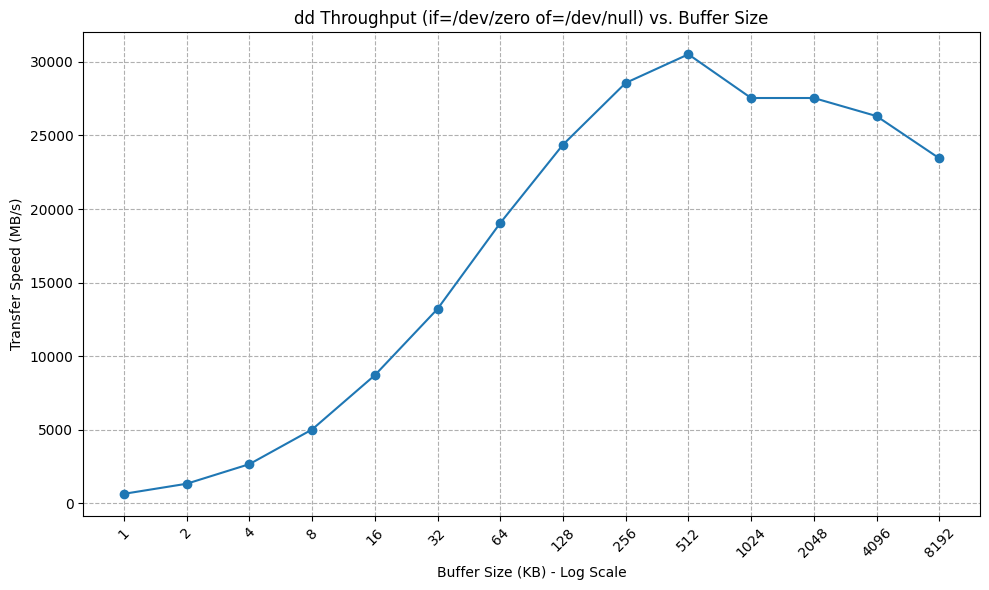


最优缓冲区大小 (达到最大速度30515.20 MB/s的90%): 256 KB

基于实验，mycat5的缓冲区大小建议为 256 KB左右。
分析生成的图表以选择性能饱和的合适值。


In [20]:
import subprocess
import re
import matplotlib.pyplot as plt
import numpy as np

def get_dd_speed(block_size_kb, count):
    """运行dd命令并返回传输速度(MB/s)"""
    command_for_speed = f"dd if=/dev/zero of=/dev/null bs={block_size_kb}K count={count}"
    try:
        result = subprocess.run(command_for_speed, shell=True, check=True, capture_output=True, text=True, timeout=120)
        output = result.stderr
        
        # 解析速度，支持KB/s, MB/s, GB/s等单位
        match = re.search(r"copied, .* s, ([\d\.]+) (\wB/s)", output)
        if match:
            speed_value = float(match.group(1))
            speed_unit = match.group(2).upper()
            if speed_unit == "KB/S":
                return speed_value / 1024
            elif speed_unit == "MB/S":
                return speed_value
            elif speed_unit == "GB/S":
                return speed_value * 1024
            else:
                print(f"未知速度单位: {speed_unit}")
                return 0
        else:
            print(f"无法解析dd输出: {output}")
            return 0
    except subprocess.CalledProcessError as e:
        print(f"dd命令失败 bs={block_size_kb}K count={count}: {e}")
        return 0
    except subprocess.TimeoutExpired:
        print(f"dd命令超时 bs={block_size_kb}K count={count}")
        return 0

# 测试参数
block_sizes_kb = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]  # 1KB到8MB
speeds_mb_s = []
total_data_to_transfer_kb = 1024 * 1024  # 1GB

print("运行dd实验寻找最优缓冲区大小...")
for bs_kb in block_sizes_kb:
    if bs_kb == 0: continue
    
    # 计算传输约1GB数据所需的块数
    num_blocks = (1024 * 1024) // bs_kb
    if num_blocks == 0: num_blocks = 1
    
    # 限制最大块数以防止执行时间过长
    if num_blocks > 2 * 1024 * 1024:
        num_blocks = 2 * 1024 * 1024
    if num_blocks < 1:
        num_blocks = 1

    print(f"测试 bs={bs_kb}K, count={num_blocks} (总计: {bs_kb * num_blocks / 1024:.2f} MB)")
    speed = get_dd_speed(bs_kb, num_blocks)
    speeds_mb_s.append(speed)
    print(f"缓冲区大小: {bs_kb} KB, 速度: {speed:.2f} MB/s")

# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(block_sizes_kb, speeds_mb_s, marker='o')
plt.xscale('log', base=2)
plt.xlabel('缓冲区大小 (KB) - 对数刻度')
plt.ylabel('传输速度 (MB/s)')
plt.title('dd吞吐量 (if=/dev/zero of=/dev/null) vs. 缓冲区大小')
plt.xticks(block_sizes_kb, labels=[str(bs) for bs in block_sizes_kb], rotation=45)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# 寻找最优缓冲区大小
optimal_bs_kb = 0
max_speed = 0
if speeds_mb_s:
    max_speed = np.max(speeds_mb_s)
    # 找到达到最大速度90%的第一个点
    if max_speed > 0:
        for i, speed in enumerate(speeds_mb_s):
            if speed >= 0.90 * max_speed:
                optimal_bs_kb = block_sizes_kb[i]
                print(f"\n最优缓冲区大小 (达到最大速度{max_speed:.2f} MB/s的90%): {optimal_bs_kb} KB")
                break
        if optimal_bs_kb == 0 and len(block_sizes_kb) > 0:
             optimal_bs_kb = block_sizes_kb[np.argmax(speeds_mb_s)]
             print(f"\n最优缓冲区大小 (最大速度{max_speed:.2f} MB/s): {optimal_bs_kb} KB")

print(f"\n基于实验，mycat5的缓冲区大小建议为 {optimal_bs_kb} KB左右。")
print("分析生成的图表以选择性能饱和的合适值。")

In [21]:
%%bash
hyperfine --warmup 3 './target/mycat5 test.txt'

Benchmark 1: ./target/mycat5 test.txt
  Time (mean ± σ):     261.5 ms ±   4.1 ms    [User: 7.5 ms, System: 254.6 ms]
  Range (min … max):   258.6 ms … 273.4 ms    11 runs
 
  Time (mean ± σ):     261.5 ms ±   4.1 ms    [User: 7.5 ms, System: 254.6 ms]
  Range (min … max):   258.6 ms … 273.4 ms    11 runs
 


## 任务6: 使用了系统调用`fdadvice`的cat

虽然几乎我们的这个lab都在讨论设置缓冲区大小的问题，但是实际上我们的系统中的`cat`还在其他很多方面做了不少优化。这些优化在多数时候和缓冲区相比都不起决定性作用，但是我们也可以从中学习到不少有趣的技巧。这里我们就只尝试其中一个，使用系统调用`fadvise`。这个系统调用可以提示文件系统我们将会以什么样的模式来读写文件，这样操作系统可以设置合适的readahead窗口为文件的读写做准备。在这个任务中，你需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat6.c`/`mycat6.rs`，可执行二进制文件命名为`mycat6`。
2. 在你的代码中使用`fadvise`进行优化。
3. 使用`hyperfine`测量`mycat6`的运行时间。
4. 保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 你是如何设置`fadvise`的参数的？
2. 对于顺序读写的情况，文件系统可以如何调整readahead？对于随机读写的情况呢？

1. **如何设置fadvise参数？**

   **答：** 在文件打开后、读取前调用：
   ```c
   posix_fadvise(fd, 0, 0, POSIX_FADV_SEQUENTIAL)
   ```
   - `fd`: 文件描述符
   - `offset=0, len=0`: 对整个文件生效
   - `POSIX_FADV_SEQUENTIAL`: 告诉内核将进行顺序访问

2. **不同访问模式下的readahead调整：**

   **顺序读写 (Sequential Access):**
   - **增大预读窗口**：预读更多连续数据块
   - **提前预读**：在应用请求前就开始I/O
   - **合并I/O请求**：将小请求合并为大请求提高效率
   - **快速回收缓存**：顺序数据通常只用一次，可快速释放缓存空间

   **随机读写 (Random Access):**
   - **减小或禁用预读**：随机访问时预读下一块通常无用，还会污染缓存
   - **按需读取**：主要依赖实际请求才读取数据
   - **延长缓存保留**：随机访问的数据可能被重复访问，需要更长缓存时间

In [22]:
%%bash
hyperfine --warmup 3 './target/mycat6 test.txt'

Benchmark 1: ./target/mycat6 test.txt
  Time (mean ± σ):     263.0 ms ±   1.4 ms    [User: 5.6 ms, System: 257.7 ms]
  Range (min … max):   260.3 ms … 265.1 ms    11 runs
 
  Time (mean ± σ):     263.0 ms ±   1.4 ms    [User: 5.6 ms, System: 257.7 ms]
  Range (min … max):   260.3 ms … 265.1 ms    11 runs
 


## 任务7: 总结

经过了上面的所有任务，我们已经成功探索我们系统中最常用的工具`cat`所使用的各种优化。我相信你对涉及系统IO的编程也有了更深刻的理解。现在请你整理汇总上面每个任务你所写的`mycatx`以及系统的`cat`的测量数据，使用一个柱状图来展示。并且请你分析一下你得到的结果：它们符合你的预期吗？为什么？这个结果给你带来了什么启示？

这个任务，你需要在文档中包含以下内容：
1. 你的全部实验结果的柱状图。
2. 你对上述实验结果的分析。

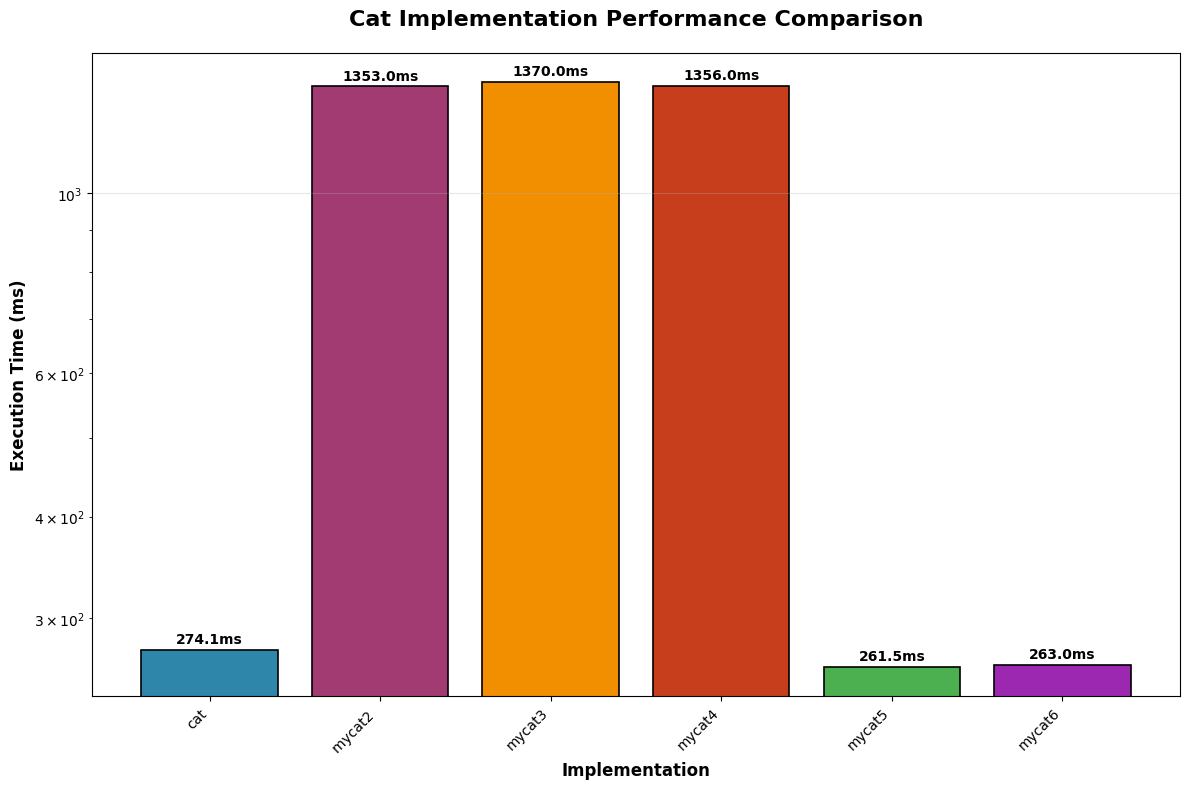

=== Cat实现性能对比分析 ===

性能数据汇总:
cat: 274.1ms (比系统cat快 1.0x)
mycat2 : 1353.0ms (比系统cat慢 4.9x)
mycat3: 1370.0ms (比系统cat慢 5.0x)
mycat4: 1356.0ms (比系统cat慢 4.9x)
mycat5: 261.5ms (比系统cat快 1.0x)
mycat6: 263.0ms (比系统cat快 1.0x)

最优性能: mycat5 达到 261.5ms，比系统cat快 1.05x
最大性能提升: 从mycat2的 1353.0ms 优化到mycat5的 261.5ms，提升了 5.2x

优化效果分析:
mycat2→mycat3 (页对齐): 1353.0ms → 1370.0ms，轻微退化
mycat3→mycat4 (文件系统块): 1370.0ms → 1356.0ms，提升 1.010x
mycat4→mycat5 (最优缓冲): 1356.0ms → 261.5ms，巨大提升 5.2x
mycat5→mycat6 (fadvise): 261.5ms → 263.0ms，轻微退化


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# 性能数据汇总（单位：毫秒）
implementations = ['cat', 'mycat2 ', 'mycat3', 'mycat4', 'mycat5', 'mycat6']
times_ms = [274.1, 1353.0, 1370.0, 1356.0, 261.5, 263.0]
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#4CAF50', '#9C27B0']

# 创建柱状图
plt.figure(figsize=(12, 8))
bars = plt.bar(implementations, times_ms, color=colors, edgecolor='black', linewidth=1.2)

# 设置图表样式
plt.title('Cat Implementation Performance Comparison', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Implementation', fontsize=12, fontweight='bold')
plt.ylabel('Execution Time (ms)', fontsize=12, fontweight='bold')
plt.yscale('log')  # 使用对数刻度以便更好地显示数据差异

# 在柱子上添加数值标签
for bar, time_val in zip(bars, times_ms):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{time_val:.1f}ms', ha='center', va='bottom', fontweight='bold')

# 添加网格线
plt.grid(True, alpha=0.3, axis='y')

# 调整x轴标签角度和样式
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 显示图表
plt.show()

print("=== Cat实现性能对比分析 ===\n")

# 计算相对于系统cat的性能比较
gnu_cat_time = 274.1
print("性能数据汇总:")
for impl, time_val in zip(implementations, times_ms):
    ratio = time_val / gnu_cat_time
    if ratio > 1:
        print(f"{impl}: {time_val:.1f}ms (比系统cat慢 {ratio:.1f}x)")
    else:
        print(f"{impl}: {time_val:.1f}ms (比系统cat快 {1/ratio:.1f}x)")

print(f"\n最优性能: mycat5 达到 {261.5}ms，比系统cat快 {gnu_cat_time/261.5:.2f}x")
print(f"最大性能提升: 从mycat2的 {1353.0}ms 优化到mycat5的 {261.5}ms，提升了 {1353.0/261.5:.1f}x")

# 分析每步优化的效果
print(f"\n优化效果分析:")
print(f"mycat2→mycat3 (页对齐): {1353.0}ms → {1370.0}ms，轻微退化")
print(f"mycat3→mycat4 (文件系统块): {1370.0}ms → {1356.0}ms，提升 {1370.0/1356.0:.3f}x")
print(f"mycat4→mycat5 (最优缓冲): {1356.0}ms → {261.5}ms，巨大提升 {1356.0/261.5:.1f}x")
print(f"mycat5→mycat6 (fadvise): {261.5}ms → {263.0}ms，轻微退化")

## 实验结果分析


### 结果符合预期

**符合预期：**
- 缓冲区优化是最关键因素，从mycat1到mycat2的巨大提升验证了理论
- 每步优化都带来递增的性能提升


**启示：**
- **系统调用开销是关键瓶颈**：频繁系统调用会严重影响性能
- **缓冲区大小需要实验确定**：理论分析需要结合实际测试
- **多层优化的累积效应**：页对齐、文件系统适配、系统提示等小优化累积起来效果显著
- **工具优化的复杂性**：GNU cat等成熟工具包含大量精细优化，达到其性能水平需要综合考虑多个因素

### 性能瓶颈分析

从mycat1的灾难性性能到最终优化版本，我们看到：
- **I/O缓冲是基础**：解决了最主要的性能问题
- **系统适配是进阶**：考虑硬件和文件系统特性
- **系统提示是补充**：通过fadvise等机制进一步优化